In [3]:
from collections import Counter

import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt
import seaborn as sns

from proxbias.utils.chromosome_info import get_chromosome_info_as_dicts
from proxbias.utils.data_utils import _get_data_path
from efaar_benchmarking.utils import get_benchmark_data

In [4]:
# obtain chromosome and gene annotations
GENES, CHROMS, _ = get_chromosome_info_as_dicts()

# read gene connectivity data from shinydepmap
shinydepmap_data = pd.read_csv(_get_data_path("shinyDepMap_19Q3_cluster_s.csv"))

# read benchmark data
reactome_gt = get_benchmark_data("Reactome")
corum_gt = get_benchmark_data("CORUM")
hu_map_gt = get_benchmark_data("HuMAP")

In [5]:
def _generate_gene_pair_key(
    df: pd.DataFrame,
    col1: str,
    col2: str,
    delim: str = "<>",
) -> list:
    """Generate order-independent gene pair keys."""
    df = df.copy()
    swap = df[col1] < df[col2]
    df.loc[swap, [col1, col2]] = df.loc[swap, [col2, col1]].values
    gpk = df[col1] + delim + df[col2]
    return gpk.tolist()


def add_arm_data(
    df: pd.DataFrame,
    col_pairs: dict = {"entity1": "entity1_arm", "entitt2": "entity2_arm"},
) -> pd.DataFrame:
    """Map arm data to a df column."""
    df = df.copy()
    for old_col, new_col in col_pairs.items():
        df[new_col] = [GENES[g]["arm"] if g in GENES else np.nan for g in df[old_col]]
    return df


def process_connectivity_calls(
    df: pd.DataFrame,
    ground_truth_keys: list,
    return_summary: bool = True,
) -> pd.DataFrame:
    """
    Process the shinyDepMap output for intra vs inter arm calls.

    df: pd.DataFrame. A data frame from shinyDepMap 19Q3
    ground_truth_keys: list. A list of ordered gene-gene pairs generated by `_generate_gene_pair_key` function
    return_summary: bool. defaut=True. Return summary stats of or raw data
    return: pd.DataFrame. A data frame with n total genes, intra-arm, inter-arm calls in each arm and odds ratio
    """
    df = df.copy()
    df["from_arm"] = [GENES[g]["arm"] if g in GENES else np.nan for g in df["from"]]
    df["to_arm"] = [GENES[g]["arm"] if g in GENES else np.nan for g in df["to"]]
    df = df.dropna()

    # generate connectivity key
    df["gg_key"] = _generate_gene_pair_key(df, col1="from", col2="to")
    df["in_ground_truth"] = [k in ground_truth_keys for k in df["gg_key"]]

    if not return_summary:
        return df

    # total number of genes on each arm
    gene_arm_counts = (
        pd.Series(
            Counter([GENES[g]["arm"] if g in GENES else np.nan for g in set(df["from"].tolist() + df["to"].tolist())])
        )
        .rename("n total genes")
        .to_frame()
    )

    # number of intra arm gene-gene connectivity calls
    intra_arm_rel = pd.Series(Counter(df[df.from_arm == df.to_arm].from_arm.tolist())).rename("intra-arm").to_frame()
    # number of documented intra arm gene-gene connectivity calls
    intra_arm_rel_in_gt = (
        pd.Series(Counter(df.query("from_arm == to_arm & in_ground_truth").from_arm.tolist()))
        .rename("intra-arm (documented)")
        .to_frame()
    )
    # number of inter arm gene-gene connectivity calls
    inter_arm_rel = (
        pd.Series(
            Counter(df.query("from_arm != to_arm").from_arm.tolist() + df.query("from_arm != to_arm").to_arm.tolist())
        )
        .rename("inter-arm/-chromosome")
        .to_frame()
    )
    # number of documented inter arm gene-gene connectivity calls
    inter_arm_rel_in_gt = (
        pd.Series(
            Counter(
                df.query("from_arm != to_arm & in_ground_truth").from_arm.tolist()
                + df.query("from_arm != to_arm & in_ground_truth").to_arm.tolist()
            )
        )
        .rename("inter-arm/-chromosome (documented)")
        .to_frame()
    )

    ggi = pd.concat(
        [
            intra_arm_rel,
            intra_arm_rel_in_gt,
            inter_arm_rel,
            inter_arm_rel_in_gt,
            gene_arm_counts,
        ],
        axis=1,
    ).fillna(0)
    ggi["odds"] = ggi["intra-arm"] / ggi["inter-arm/-chromosome"]

    return ggi


def compute_gt_odds_ratio(gt_df: pd.DataFrame, col1: str = "entity1", col2: str = "entity2"):
    """
    Process the ground truth df for intra vs inter arm calls.

    gt_df: pd.DataFrame. A data frame from ground truth dataset
    col1: str. A column name that contains entity1. default = "entity1"
    col2: str. A column name that contains entity2. default = "entity2"
    return: pd.DataFrame. A data frame with number of intra- and inter-arm calls and the odds ratio
    """
    col1_arm = f"{col1}_arm"
    col2_arm = f"{col2}_arm"
    gene_pairs = {col1: col1_arm, col2: col2_arm}

    # add arm annotations
    gt_df_w_arms = add_arm_data(gt_df, gene_pairs).dropna(axis=0, subset=[col1_arm, col2_arm])

    # number of intra arm connectivity calls
    intra_arm_rel = (
        pd.Series(Counter(gt_df_w_arms[gt_df_w_arms[col1_arm] == gt_df_w_arms[col2_arm]][col1_arm].tolist()))
        .rename("intra-arm")
        .to_frame()
    )
    # number of inter arm / inter chromosome connectivity calls
    inter_arm_rel = (
        pd.Series(
            Counter(
                gt_df_w_arms[gt_df_w_arms[col1_arm] != gt_df_w_arms[col2_arm]][col1_arm].tolist()
                + gt_df_w_arms[gt_df_w_arms[col1_arm] != gt_df_w_arms[col2_arm]][col2_arm].tolist()
            )
        )
        .rename("inter-arm/-chromosome")
        .to_frame()
    )

    gt_arm_summary = pd.concat([intra_arm_rel, inter_arm_rel], axis=1).fillna(0)
    gt_arm_summary["odds"] = gt_arm_summary["intra-arm"] / gt_arm_summary["inter-arm/-chromosome"]
    return gt_arm_summary

In [6]:
reactome_gt_keys = _generate_gene_pair_key(reactome_gt, col1="entity1", col2="entity2")
corum_gt_keys = _generate_gene_pair_key(corum_gt, col1="entity1", col2="entity2")
hu_map_gt_keys = _generate_gene_pair_key(hu_map_gt, col1="entity1", col2="entity2")

gt_keys = set(reactome_gt_keys + corum_gt_keys + hu_map_gt_keys)
crispr_ggi_summary = process_connectivity_calls(shinydepmap_data, gt_keys)

# reorder index based on chromosomal arm index
# remove chrX because such data is missing in 19Q3
arm_order = [ch + arm for ch in CHROMS for arm in ["p", "q"] if (ch + arm) in crispr_ggi_summary.index and ch != "chrX"]
crispr_ggi_summary = crispr_ggi_summary.loc[arm_order]

In [7]:
crispr_ggi_summary

,intra-arm,intra-arm (documented),inter-arm/-chromosome,inter-arm/-chromosome (documented),n total genes,odds
chr1p,238.0,7.0,671,128.0,298,0.354694
chr1q,339.0,2.0,563,112.0,218,0.602131
chr2p,87.0,3.0,380,86.0,124,0.228947
chr2q,74.0,8.0,524,120.0,164,0.141221
chr3p,53.0,1.0,355,77.0,120,0.149296
chr3q,43.0,2.0,407,107.0,121,0.105651
chr4p,4.0,0.0,115,31.0,33,0.034783
chr4q,20.0,0.0,273,66.0,87,0.073260
chr5p,7.0,0.0,103,27.0,27,0.067961
chr5q,67.0,2.0,427,92.0,155,0.156909


### Figure 3D
Boxen plots showing distributions of the ratio of within-chromosome arm relationships to between-arm relationships for each chromosome arm across different gene annotation sets. The DepMap data shows a much higher ratio of within-arm to between arm annotations suggesting a systematic bias to the predicted associations.

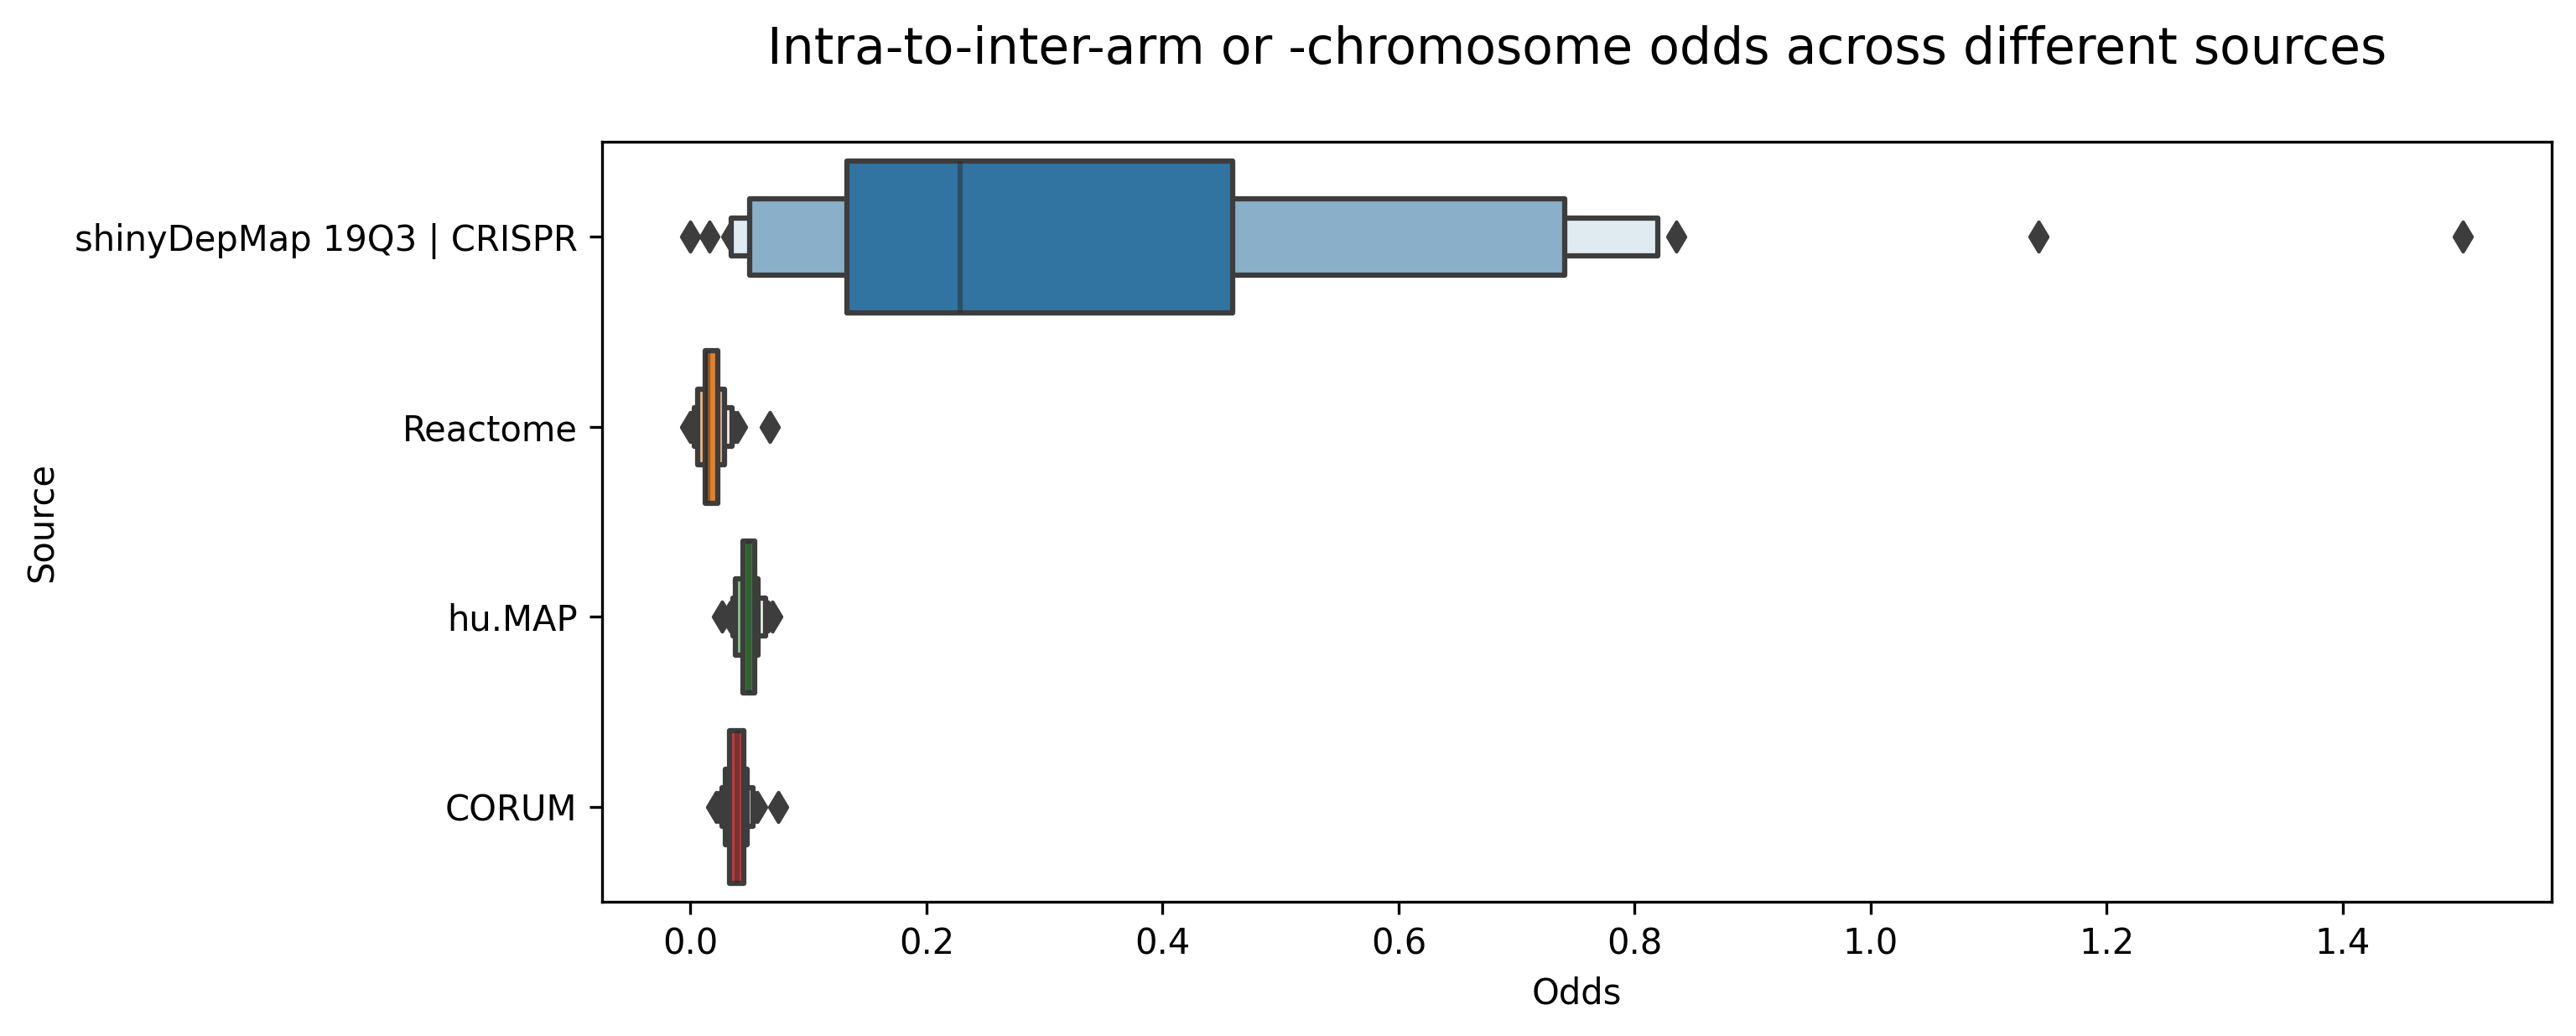

In [8]:
gt_odds_summary = pd.concat(
    [
        crispr_ggi_summary.assign(lib="shinyDepMap 19Q3 | CRISPR"),
        compute_gt_odds_ratio(reactome_gt).assign(lib="Reactome"),
        compute_gt_odds_ratio(hu_map_gt).assign(lib="hu.MAP"),
        compute_gt_odds_ratio(corum_gt).assign(lib="CORUM"),
    ]
).loc[arm_order]

fig = plt.figure(figsize=(10, 4), dpi=300, facecolor="white")
p = sns.boxenplot(data=gt_odds_summary, y="lib", x="odds", linewidth=1.5, k_depth=3)
plt.ylabel("Source")
plt.xlabel("Odds")
plt.title("Intra-to-inter-arm or -chromosome odds across different sources\n", size="x-large")

plt.rcParams["svg.fonttype"] = "none"
plt.gcf().set_facecolor("white")
plt.savefig("shinydepmap_19q3_odds_300dpi.svg", format="svg", bbox_inches="tight")
plt.show()

### Supplementary Fig. 3B
Counts of gene-gene relationships within and between chromosome arms for shinyDepMap 19Q3 data (blue and tan) and public annotation sets (Reactome, HuMAP and CORUM) (green and red) [Gillepsie2022, Drew2021, Giurgiu2019]. DepMap predicts a much higher proportion of within-chromosome arm relationships than are found in public annotation sets.

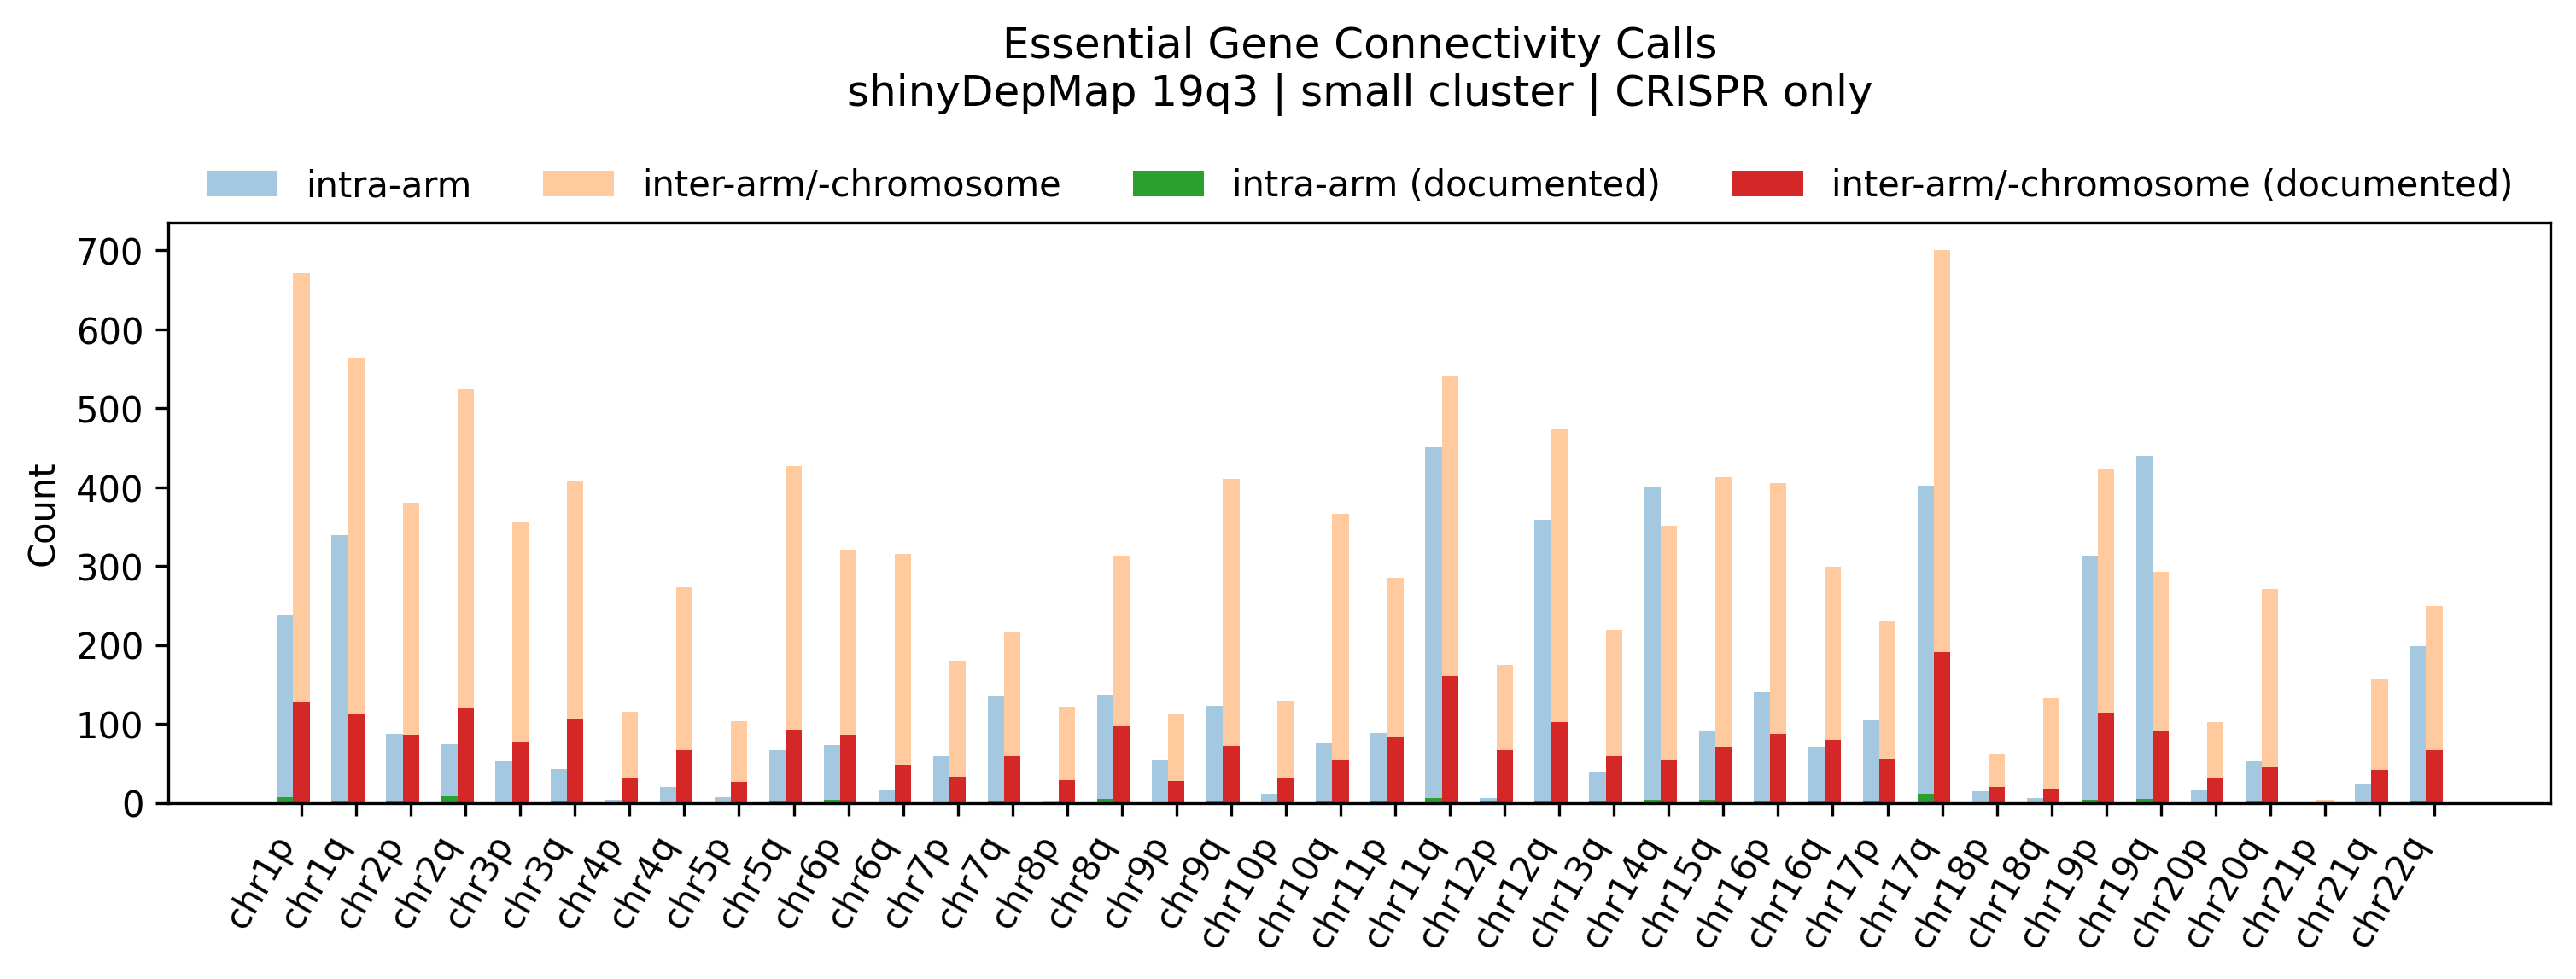

In [9]:
fig = plt.figure(figsize=(12, 3), dpi=300, facecolor="white")
bar_width = 0.3

# bars for total number of inter and intra calls
x = np.arange(crispr_ggi_summary.shape[0])
multiplier = 0
for rel in [("intra-arm", "#1f77b4"), ("inter-arm/-chromosome", "#ff7f0e")]:
    offset = bar_width * multiplier
    rects = plt.bar(x + offset, crispr_ggi_summary[rel[0]], bar_width, label=rel[0], alpha=0.4, color=rel[1])
    multiplier += 1

# overlap documented bars on top of total bars
x = np.arange(crispr_ggi_summary.shape[0])
multiplier = 0
for rel in [("intra-arm (documented)", "#2ca02c"), ("inter-arm/-chromosome (documented)", "#d62728")]:
    offset = bar_width * multiplier
    rects = plt.bar(x + offset, crispr_ggi_summary[rel[0]], bar_width, label=rel[0], color=rel[1])
    multiplier += 1

plt.ylabel("Count")
plt.title("Essential Gene Connectivity Calls\nshinyDepMap 19q3 | small cluster | CRISPR only\n\n", size="large")
plt.xticks(x + bar_width, crispr_ggi_summary.index, rotation=60, ha="right")
plt.legend(loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.15), frameon=False)

plt.rcParams["svg.fonttype"] = "none"
plt.gcf().set_facecolor("white")
plt.savefig("shinydepmap_19q3_connectivity_300dpi.svg", format="svg", bbox_inches="tight")
plt.show()

### Statistical test
Fisher exact test of the documented over undocumented shinyDepMap calls between intra and inter arm

In [10]:
# [ intra_gt,    inter_gt    ]
# [ intra_other, inter_other ]
call_summary = crispr_ggi_summary.sum()
call_summary = np.array(
    [
        [
            call_summary["intra-arm (documented)"],
            call_summary["inter-arm/-chromosome (documented)"],
        ],
        [
            call_summary["intra-arm"] - call_summary["intra-arm (documented)"],
            call_summary["inter-arm/-chromosome"] - call_summary["inter-arm/-chromosome (documented)"],
        ],
    ]
)
fisher_stat, fisher_pvalue = scipy.stats.fisher_exact(call_summary, alternative="two-sided")
print(call_summary)
print(f"N = {int(call_summary.sum())}")
print(f"Fisher exact odds ratio = {fisher_stat:.5f}, pvalue = {fisher_pvalue}")

[[  98. 2825.]
 [4737. 9261.]]
N = 16921
Fisher exact odds ratio = 0.06782, pvalue = 1.166e-321
